In [1]:
import numpy as np
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from hyperspectral.band_selection import *
from hyperspectral.math import zca_whitening_matrix

%matplotlib inline

# Load #

Load stored data.
   1. `landfill` contains hyperspectral imagery containing a landfill that has plastic in it
   2. `background` contains hyperspectral imagery of a nearby area with "no" plastic in it
   3. `spectrum` contains a plastic spectrum
These data are from the `target_detection.ipynb` notebook where they were saved with an `np.savez` command.

In [2]:
data = np.load('data/landfill_clear_plastic.npz')
landfill = data['arr_0']
background = data['arr_1']
spectrum = data['arr_2']
spectrum[np.isnan(spectrum)] = 0

# Training Data #

Generate whitening (or sphering or decorrelating) matrix using theory.

In [3]:
W, mean = zca_whitening_matrix(background)

Generate centered imagery and a centered spectrum by subtracting the channel means of the background imagery.

In [4]:
(x, y, c) = background.shape
centered_background_pixels = (background-mean).reshape(-1, c)
centered_landfill_pixels = (landfill-mean).reshape(-1, c)
centered_plastic_pixels = np.tile(spectrum-mean, (x*y, 1))
centered_spectrum = (spectrum-mean).reshape(-1, 1)

Sanity check: do matched-filter computation using matrix multiplication.  The highest and lowest responses are also captured for future use (for scaling).

In [5]:
fg = np.matmul(np.matmul(centered_landfill_pixels, W), centered_spectrum).reshape(x, y, -1)
bg = np.matmul(np.matmul(centered_background_pixels, W), centered_spectrum).reshape(x, y, -1)
pl = np.matmul(np.matmul(centered_plastic_pixels, W), centered_spectrum).reshape(x, y, -1)

-746.1797236283862 111.9984771359624


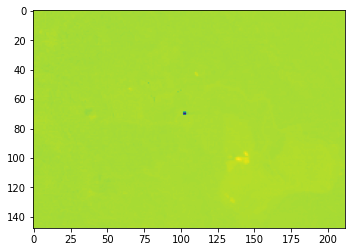

In [6]:
plt.imshow(fg)
print(np.min(fg), np.max(fg))

-52.76266587327678 80.50847623533636


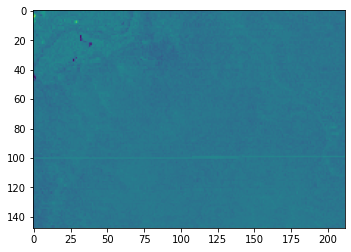

In [7]:
plt.imshow(bg)
print(np.min(bg), np.max(bg))

262.63860632715796 262.6386063271581


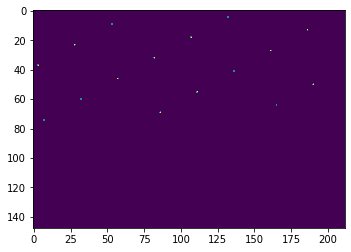

In [8]:
plt.imshow(pl)
print(np.min(pl), np.max(pl))

In [9]:
lo = min(np.min(bg), np.min(pl))
hi = max(np.max(bg), np.max(pl))

Next the scale and the bias are computed using the minima and maxima computed above.

In [10]:
scale = 1/(hi - lo)
bias = -lo * scale

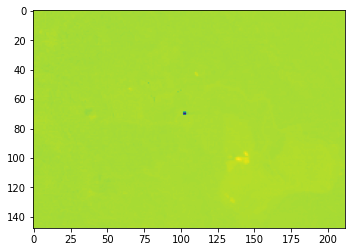

In [11]:
plt.imshow(fg * scale + bias)

For completeness, show the scaled results.

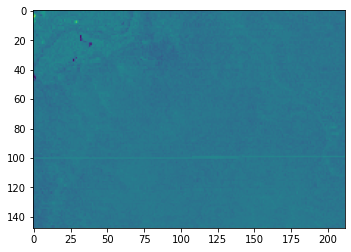

In [12]:
plt.imshow(bg * scale + bias)

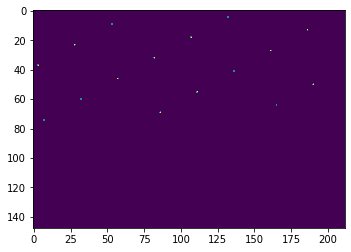

In [13]:
plt.imshow(pl * scale + bias)

# PyTorch Module #

In [14]:
device = torch.device("cuda")
# device = torch.device("cpu")

## Use Module ##

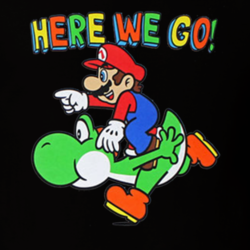

We will start by first producing tensors containing the background imagery concatenated with copies of the plastic spectrum, and we will also produce corresponding labels.  These negative and positive pixels will be used for "training" the filter.

In [15]:
ps = np.concatenate([centered_background_pixels, centered_plastic_pixels], 0)
ps = torch.from_numpy(ps.astype(np.float)).unsqueeze(2).to(device)

ps2 = torch.from_numpy(centered_landfill_pixels.astype(np.float)).unsqueeze(2).to(device)

ls = np.concatenate([np.zeros((x*y, 1)), np.ones((x*y, 1))])
ls = torch.from_numpy(ls.astype(np.float)).unsqueeze(2).to(device)

v = torch.from_numpy(centered_spectrum.astype(np.float)).unsqueeze(0).to(device)

Now use the whitening operator (computed above using theory) and the bias (also computed above) as a starting point for the PyTorch model.

In [16]:
model = MatchedFilter(W*scale, bias).to(device)

Take a look at the operator before training.

[0.16728742]


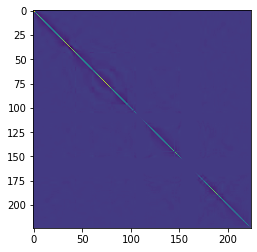

In [17]:
before = model.W.cpu().detach().numpy()
print(model.bias.cpu().detach().numpy())
plt.imshow(before)

Take a look at the results of the matched-filter before training.

0.12413181673910333 0.29256366013417956


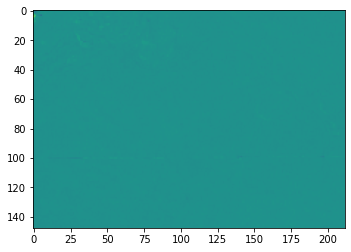

In [18]:
blah = model(ps, v).cpu().detach().numpy()
blah = blah.reshape(x*2, y, 1)[:x, :, :]
plt.imshow(blah, vmin=0.0, vmax=0.33)
print(np.min(blah), np.max(blah))

0.0 0.3221330748895815


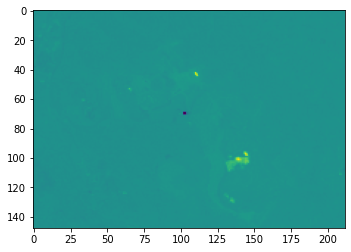

In [19]:
blah = model(ps2, v).cpu().detach().numpy().reshape((x, y, 1))
plt.imshow(blah, vmin=0.0, vmax=0.33)
print(np.min(blah), np.max(blah))

Now **train the matched filter** using labeled pixels `ps` (recall that these are a concatenation of background pixels and copies of the plastic spectum).

In [20]:
model = vanilla_train(model, ps, ls, v, device, 1000)

Take a look at the operator after optimization.  Visually, it looks pretty similar.

[-0.00130196]


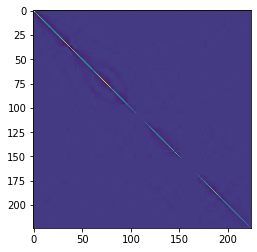

In [21]:
after = model.W.cpu().detach().numpy()
print(model.bias.cpu().detach().numpy())
plt.imshow(after)

Now take a look at the difference between the trained and untrained operator.

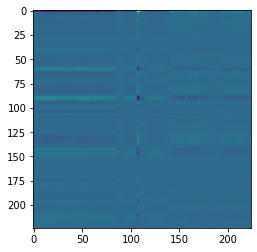

In [22]:
plt.imshow(before-after)

Let's take a look at the results that the trained model produces.  The trained results have much greater contrast and better calibration.

In [23]:
blah1 = model(ps, v).cpu().detach().numpy().reshape(x*2, y, 1)[:x, :, :]
blah2 = model(ps2, v).cpu().detach().numpy().reshape(x, y, 1)

In [24]:
print(np.min(blah1), np.max(blah1))
print(np.min(blah2), np.max(blah2))

0.0 0.8961494248141527
0.0 1.3937435740284312


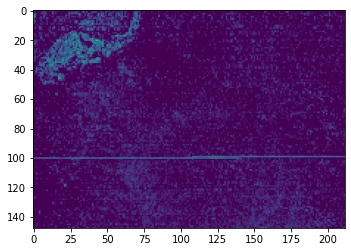

In [25]:
plt.imshow(blah1, vmin=0.0, vmax=1.09)

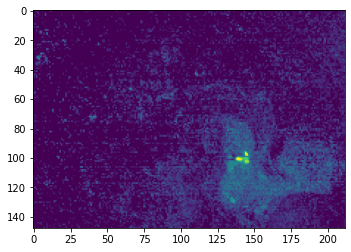

In [26]:
plt.imshow(blah2, vmin=0.0, vmax=1.09)

# Salience-Based Band Selection #

Let's compute the most salient bands.  We will choose the indices of some known-positive pixels and ask for the bands that activate positive responses.  (Note that the known-positive pixels are just copies of the plastic spectrum because `ps` is a concatenation of background imagery and copies of the plastic spectrum, and there are < 60000 background pixels.)

In [27]:
positive_pixel_indices = [60000, 60001]
according_to_salience = argsort(model, ps, v, positive_pixel_indices)

These are the 50 best bands.

In [28]:
according_to_salience[-50:]

array([[ 46],
       [ 11],
       [134],
       [181],
       [194],
       [105],
       [135],
       [142],
       [ 36],
       [ 53],
       [ 77],
       [ 52],
       [ 42],
       [130],
       [  4],
       [ 50],
       [132],
       [209],
       [133],
       [146],
       [ 64],
       [ 63],
       [129],
       [143],
       [147],
       [ 78],
       [144],
       [131],
       [ 51],
       [ 67],
       [ 81],
       [ 65],
       [ 66],
       [ 94],
       [ 85],
       [ 96],
       [ 82],
       [ 59],
       [ 88],
       [ 92],
       [ 83],
       [ 84],
       [ 61],
       [ 95],
       [ 60],
       [ 89],
       [ 91],
       [ 90],
       [  0],
       [  1]])

# 50 Bands #

## 50 "Best" Bands ##

In [ ]:
background50 = background[:, :, according_to_saliency[-50:]].squeeze()
landfill50 = landfill[:, :, according_to_saliency[-50:]].squeeze()
spectrum50 = spectrum[according_to_saliency[-50:]].squeeze()

## 50 "Best" Bands ex Outliers ##

In [29]:
background50 = background[:, :, according_to_salience[-52:-2]].squeeze()
landfill50 = landfill[:, :, according_to_salience[-52:-2]].squeeze()
spectrum50 = spectrum[according_to_salience[-52:-2]].squeeze()

## 50 "Worst" Bands ##

In [ ]:
background50 = background[:, :, according_to_saliency[:50]].squeeze()
landfill50 = landfill[:, :, according_to_saliency[:50]].squeeze()
spectrum50 = spectrum[according_to_saliency[:50]].squeeze()

## Compute ##

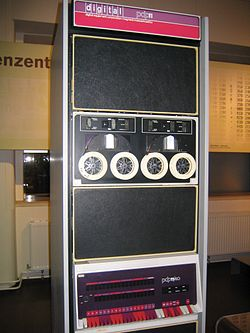

Above, we chose 50 bands.  Now we will see how they perform.

In [30]:
W50, mean50 = zca_whitening_matrix(background50)

In [31]:
centered_background_pixels50 = (background50-mean50).reshape(-1, 50)
centered_landfill_pixels50 = (landfill50-mean50).reshape(-1, 50)
centered_plastic_pixels50 = np.tile(spectrum50-mean50, (x*y, 1))
centered_spectrum50 = (spectrum50-mean50).reshape(-1, 1)

In [32]:
fg50 = np.matmul(np.matmul(centered_landfill_pixels50, W50), centered_spectrum50).reshape(x, y, -1)
bg50 = np.matmul(np.matmul(centered_background_pixels50, W50), centered_spectrum50).reshape(x, y, -1)
pl50 = np.matmul(np.matmul(centered_plastic_pixels50, W50), centered_spectrum50).reshape(x, y, -1)

In [33]:
print(np.min(bg50), np.max(bg50))
print(np.min(fg50), np.max(fg50))

-10.59943809362734 37.58900045680936
-122.59025200739347 52.373550767177015


In [34]:
lo50 = min(np.min(bg50), np.min(pl50))
hi50 = max(np.max(bg50), np.max(pl50))
scale50 = 1/(hi50 - lo50)
bias50 = -lo50 * scale50

In [35]:
ps50 = np.concatenate([centered_background_pixels50, centered_plastic_pixels50], 0)
ps50 = torch.from_numpy(ps50.astype(np.float)).unsqueeze(2).to(device)

ps2_50 = torch.from_numpy(centered_landfill_pixels50.astype(np.float)).unsqueeze(2).to(device)

ls50 = np.concatenate([np.zeros((x*y, 1)), np.ones((x*y, 1))])
ls50 = torch.from_numpy(ls50.astype(np.float)).unsqueeze(2).to(device)

v50 = torch.from_numpy(centered_spectrum50.astype(np.float)).unsqueeze(0).to(device)

Create a 50-band model (starting from the theory-derived operator).

In [36]:
model50 = MatchedFilter(W50*scale50, bias50).to(device)

These are the results of the untrained 50-band model.

0.0 0.7269429046967428


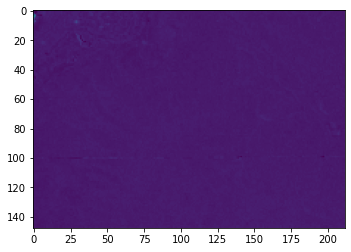

In [37]:
blah = model50(ps50, v50).cpu().detach().numpy()
blah = blah.reshape(x*2, y, 1)[:x, :, :]
plt.imshow(blah, vmin=0.0, vmax=1.15)
print(np.min(blah), np.max(blah))

0.0 0.9339073725016687


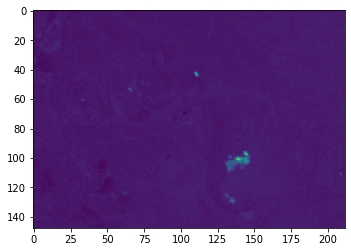

In [38]:
blah = model50(ps2_50, v50).cpu().detach().numpy().reshape((x, y, 1))
plt.imshow(blah, vmin=0.0, vmax=1.15)
print(np.min(blah), np.max(blah))

Now we will train the 50-band model.

In [39]:
model50 = vanilla_train(model50, ps50, ls50, v50, device, 1000)

Let's examine the results of the trained 50-band model.

In [40]:
blah1 = model50(ps50, v50).cpu().detach().numpy().reshape(x*2, y, 1)[:x, :, :]
blah2 = model50(ps2_50, v50).cpu().detach().numpy().reshape(x, y, 1)
print(np.min(blah1), np.max(blah1))
print(np.min(blah2), np.max(blah2))

0.0 0.7700718251451336
0.0 1.0608499871943196


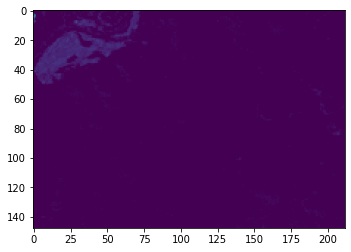

In [41]:
plt.imshow(blah1, vmin=0.0, vmax=np.max(blah2))

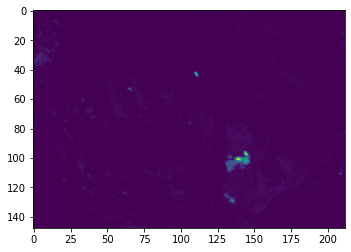

In [42]:
plt.imshow(blah2, vmin=0.0, vmax=np.max(blah2))